In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from typing import Tuple, List, Optional, Any, Callable, Dict, Union
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import roc_auc_score
import random
from typeguard import typechecked

In [2]:
random.seed(42)
np.random.seed(42)

In [3]:
@typechecked
def read_data(filename: str) -> pd.DataFrame:
    """
    Read the data from the filename. Load the data it in a dataframe and return it.
    """
    return pd.read_csv(filename)

In [4]:
@typechecked
def data_preprocess(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Follow all the preprocessing steps mentioned in Problem 2 of HW2 (Problem 2: Coding: Preprocessing the Data.)
    Return the final features and final label in same order
    You may use the same code you submiited for problem 2 of HW2
    """

    df = df.dropna()
    df = df.drop(['Player'], axis=1)
    feature = df.drop(['NewLeague'], axis=1)
    df_numerical = feature.select_dtypes(include=['int64', 'float64'])
    df_categorical = feature.select_dtypes(exclude=['int64', 'float64'])
    df_categorical = pd.get_dummies(df_categorical)
    labels = pd.Series(df['NewLeague'])
    labels = labels.replace('A', 0)
    labels = labels.replace('N', 1)
    return pd.concat([df_categorical, df_numerical], axis=1), labels

In [5]:
@typechecked
def data_split(
    features: pd.DataFrame, label: pd.Series, test_size: float
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """
    Split 80% of data as a training set and the remaining 20% of the data as testing set
    return training and testing sets in the following order: X_train, X_test, y_train, y_test
    """
    X_train, X_test, y_train, y_test = train_test_split(
        features, label, test_size=test_size)
    return X_train, X_test,  y_train,  y_test

In [6]:
@typechecked
def train_ridge_regression(
    x_train: pd.DataFrame,
    y_train: pd.Series,
    x_test: pd.DataFrame,
    y_test: pd.Series,
    max_iter: int = int(1e8),
) -> Dict[float, float]:
    """
    Instantiate an object of Ridge Regression, train the model object using training data for the given `n'
    iterations and in each iteration train the model for all lambda_vals as alpha and store roc scores of all lambda
    values in all iterations in aucs dictionary

    Rest of the provided handles the return part
    """
    n = int(1e3)
    aucs = {"ridge": []}
    lambda_vals = [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]

    for i in range(n):
        for lambda_val in lambda_vals:
            ridge = Ridge(alpha=lambda_val, max_iter=max_iter)
            ridge.fit(x_train, y_train)
            auc = roc_auc_score(y_test, ridge.predict(x_test))
            aucs["ridge"].append({lambda_val: auc})

    print("ridge mean AUCs:")
    ridge_mean_auc = {}
    ridge_aucs = pd.DataFrame(aucs["ridge"])
    for lambda_val, ridge_auc in zip(lambda_vals, ridge_aucs.mean()):
        ridge_mean_auc[lambda_val] = ridge_auc
        print("lambda:", lambda_val, "AUC:", "%.4f" % ridge_auc)
    return ridge_mean_auc

In [7]:
@typechecked
def train_lasso(
    x_train: pd.DataFrame,
    y_train: pd.Series,
    x_test: pd.DataFrame,
    y_test: pd.Series,
    max_iter=int(1e8),
) -> Dict[float, float]:
    """
    Instantiate an object of Lasso Model, train the object using training data for the given `n'
    iterations and in each iteration train the model for all lambda_vals as alpha and store roc scores of all lambda
    values in all iterations in aucs dictionary

    Rest of the provided handles the return part
    """
    n = int(1e3)
    aucs = {"lasso": []}
    lambda_vals = [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]

    for i in range(n):
        for lambda_val in lambda_vals:
            lasso = Lasso(alpha=lambda_val, max_iter=max_iter)
            lasso.fit(x_train, y_train)
            auc = roc_auc_score(y_test, lasso.predict(x_test))
            aucs["lasso"].append({lambda_val: auc})

    print("lasso mean AUCs:")
    lasso_mean_auc = {}
    lasso_aucs = pd.DataFrame(aucs["lasso"])
    for lambda_val, lasso_auc in zip(lambda_vals, lasso_aucs.mean()):
        lasso_mean_auc[lambda_val] = lasso_auc
        print("lambda:", lambda_val, "AUC:", "%.4f" % lasso_auc)

    return lasso_mean_auc

In [8]:
@typechecked
def ridge_coefficients(
    x_train: pd.DataFrame,
    y_train: pd.Series,
    optimal_alpha: float,
    max_iter=int(1e8),
) -> Tuple[Ridge, np.ndarray]:
    """
    return the tuple consisting of trained Ridge model with alpha as optimal_alpha and the coefficients
    of the model
    """
    ridge = Ridge(alpha=optimal_alpha, max_iter=max_iter)
    ridge.fit(x_train, y_train)
    return ridge, ridge.coef_

In [9]:
@typechecked
def lasso_coefficients(
    x_train: pd.DataFrame,
    y_train: pd.Series,
    optimal_alpha: float,
    max_iter=int(1e8),
) -> Tuple[Lasso, np.ndarray]:
    """
    return the tuple consisting of trained Lasso model with alpha as optimal_alpha and the coefficients
    of the model
    """
    lasso = Lasso(alpha=optimal_alpha, max_iter=max_iter)
    lasso.fit(x_train, y_train)
    return lasso, lasso.coef_

In [10]:
@typechecked
def ridge_area_under_curve(
    model_R, x_test: pd.DataFrame, y_test: pd.Series
) -> float:
    """
    return area under the curve measurements of trained Ridge model used to find coefficients,
    i.e., model tarined with optimal_aplha
    Finally plot the ROC Curve using false_positive_rate, true_positive_rate as x and y axes calculated from roc_curve
    """
    auc = roc_auc_score(y_test, model_R.predict(x_test))
    return auc

In [11]:
@typechecked
def lasso_area_under_curve(
    model_L, x_test: pd.DataFrame, y_test: pd.Series
) -> float:
    """
    return area under the curve measurements of Lasso Model,
    i.e., model tarined with optimal_aplha
    Finally plot the ROC Curve using false_positive_rate, true_positive_rate as x and y axes calculated from roc_curve
    """
    auc = roc_auc_score(y_test, model_L.predict(x_test))
    return auc

In [12]:
class Node:
    @typechecked
    def __init__(
        self,
        split_val: float,
        data: Any = None,
        left: Any = None,
        right: Any = None,
    ) -> None:
        if left is not None:
            assert isinstance(left, Node)

        if right is not None:
            assert isinstance(right, Node)

        self.left = left
        self.right = right
        # value (of a variable) on which to split. For leaf nodes this is label/output value
        self.split_val = split_val
        self.data = data  # data can be anything! we recommend dictionary with all variables you need

In [13]:
class TreeRegressor:
    @typechecked
    def __init__(self, data: np.ndarray, max_depth: int) -> None:
        self.data = (
            data  # last element of each row in data is the target variable
        )
        self.max_depth = max_depth  # maximum depth
        # YOU MAY ADD ANY OTHER VARIABLES THAT YOU NEED HERE
        # YOU MAY ALSO ADD FUNCTIONS **WITHIN CLASS or functions INSIDE CLASS** TO HELP YOU ORGANIZE YOUR BETTER
        # YOUR CODE HERE

    @typechecked
    def build_tree(self) -> Node:
        """
        Build the tree
        """
        root = self.get_best_split(self, self.data)
        self.split(root, 1)
        return root

    @typechecked
    def mean_squared_error(
        self, left_split: np.ndarray, right_split: np.ndarray
    ) -> float:
        """
        Calculate the mean squared error for a split dataset
        left split is a list of rows of a df, rightmost element is label
        return the sum of mse of left split and right split
        """
        left_target = left_split[:, -1]
        left_mean = left_target.mean()
        left_mse = ((left_target - left_mean) ** 2).sum()

        right_target = right_split[:, -1]
        right_mean = right_target.mean()
        right_mse = ((right_target - right_mean) ** 2).sum()

        return (left_mse + right_mse) / len(self.data)

    @typechecked
    def split(self, node: Node, depth: int) -> None:
        """
        Do the split operation recursively
        """
        left_data, right_data = node.data['data'], node.data['data']
        left_rows, right_rows = [], []
        if depth >= self.max_depth or len(left_data) == 0 or len(right_data) == 0:
            # If we've reached maximum depth or one of the datasets is empty, stop recursion and set node as leaf
            node.left = Node(split_val=np.mean(left_data[:, -1]), data={'data': left_data})
            node.right = Node(split_val=np.mean(right_data[:, -1]), data={'data': right_data})
            return
        
        best_split = self.get_best_split(node.data)
        if best_split is None:
            # If we couldn't find a valid split, set node as leaf
            node.left = Node(split_val=np.mean(left_data[:, -1]), data={'data': left_data})
            node.right = Node(split_val=np.mean(right_data[:, -1]), data={'data': right_data})
            return
        
        index, value = best_split['index'], best_split['value']
        left_data, right_data = self.one_step_split(index, value, node.data['data'])
        node.left = Node(split_val=value, data={'data': left_data})
        node.right = Node(split_val=value, data={'data': right_data})
        self.split(node.left, depth+1)
        self.split(node.right, depth+1)

    @typechecked
    def get_best_split(self, data: np.ndarray) -> Node:
        """
        Select the best split point for a dataset AND create a Node
        """
        best_index, best_value, best_score, best_splits = float('inf'), float('inf'), float('inf'), None
        num_variables = len(data[0]) - 1  # last column is the target

        for index in range(num_variables):
            for row in data:
                left, right = self.one_step_split(index, row[index], data)
                if len(left) == 0 or len(right) == 0:
                    continue

                mse = self.mean_squared_error(left, right)
                if mse < best_score:
                    best_index, best_value, best_score, best_splits = (
                        index,
                        row[index],
                        mse,
                        (left, right),
                    )

        if best_splits is None:
            # no split made, return the mean
            return Node(split_val=data[:, -1].mean())

        left, right = [self.build_tree(split) for split in best_splits]
        return Node(split_val=best_value, data={"index": best_index}, left=left, right=right)

    @typechecked
    def one_step_split(
        self, index: int, value: float, data: np.ndarray
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Split a dataset based on an attribute and an attribute value
        index is the variable to be split on (left split < threshold)
        returns the left and right split each as list
        each list has elements as `rows' of the df
        """
        left = data[data[:, index] < value]
        right = data[data[:, index] >= value]
        return left, right

In [14]:
@typechecked
def compare_node_with_threshold(node: Node, row: np.ndarray) -> bool:
    """
    Return True if node's value > row's value (of the variable)
    Else False
    """
    return node.split_val > row[node.split_val]

In [15]:
@typechecked
def predict(
    node: Node, row: np.ndarray, comparator: Callable[[Node, np.ndarray], bool]
) -> float:
    ######################
    ### YOUR CODE HERE ###
    ######################
    pass

In [16]:
class TreeClassifier(TreeRegressor):
    def build_tree(self):
        # Note: You can remove this if you want to use build tree from Tree Regressor
        super().build_tree()

    @typechecked
    def gini_index(
        self,
        left_split: np.ndarray,
        right_split: np.ndarray,
        classes: List[float],
    ) -> float:
        """
        Calculate the Gini index for a split dataset
        Similar to MSE but Gini index instead
        """
        n_instances = float(len(left_split) + len(right_split))
        gini = 0.0
        for split in [left_split, right_split]:
            size = float(len(split))
            # Avoid division by zero
            if size == 0:
                continue
            score = 0.0
            # Score the split based on the score for each class
            for class_val in classes:
                p = [row[-1] for row in split].count(class_val) / size
                score += p * p
            # Weight the group score by its relative size
            gini += (1.0 - score) * (size / n_instances)
        return gini

    @typechecked
    def get_best_split(self, data: np.ndarray) -> Node:
        """
        Select the best split point for a dataset
        """
        classes = list(set(row[-1] for row in data))
        best_index, best_value, best_score, best_groups = float('inf'), float('inf'), float('inf'), None
        for index in range(data.shape[1] - 1):
            for row in data:
                groups = self.test_split(index, row[index], data)
                gini = self.gini_index(groups[0], groups[1], classes)
                if gini < best_score:
                    best_index, best_value, best_score, best_groups = index, row[index], gini, groups
        return Node(index=best_index, value=best_value, left=self.build_tree(best_groups[0]), right=self.build_tree(best_groups[1]))

ridge mean AUCs:
lambda: 0.001 AUC: 0.9531
lambda: 0.01 AUC: 0.9531
lambda: 0.1 AUC: 0.9545
lambda: 1 AUC: 0.9560
lambda: 10.0 AUC: 0.9751
lambda: 100.0 AUC: 0.9648
lambda: 1000.0 AUC: 0.7610
{0.001: 0.9530791788856304, 0.01: 0.9530791788856304, 0.1: 0.9545454545454544, 1: 0.9560117302052785, 10.0: 0.9750733137829911, 100.0: 0.9648093841642228, 1000.0: 0.7609970674486803}
lasso mean AUCs:
lambda: 0.001 AUC: 0.9560
lambda: 0.01 AUC: 0.9604
lambda: 0.1 AUC: 0.9707
lambda: 1 AUC: 0.5249
lambda: 10.0 AUC: 0.3651
lambda: 100.0 AUC: 0.5000
lambda: 1000.0 AUC: 0.5000


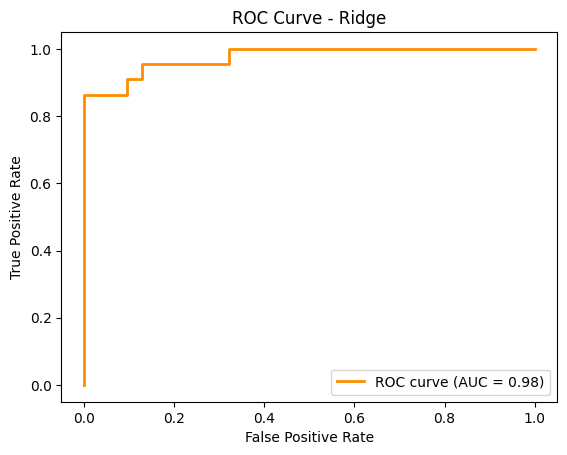

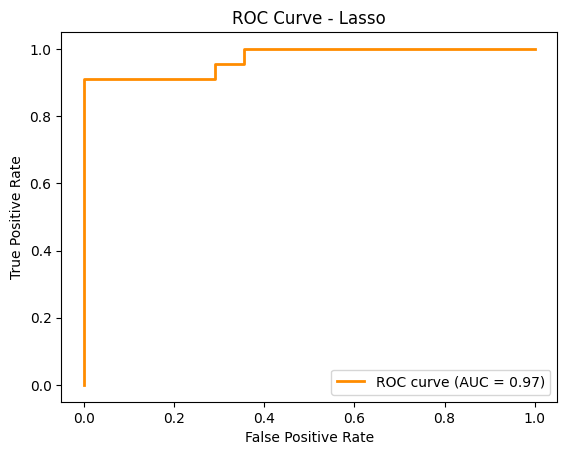

In [17]:
# # Question 1
filename = "./Hitters.csv"  # Provide the path of the dataset
df = read_data(filename)
lambda_vals = [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]
max_iter = 1e8
final_features, final_label = data_preprocess(df)
x_train, x_test, y_train, y_test = data_split(
    final_features, final_label, 0.2
)
ridge_mean_acu = train_ridge_regression(x_train, y_train, x_test, y_test)
print(ridge_mean_acu)
lasso_mean_acu = train_lasso(x_train, y_train, x_test, y_test)
model_R, ridge_coeff = ridge_coefficients(x_train, y_train, 10)
model_L, lasso_coeff = lasso_coefficients(x_train, y_train, 0.1)
ridge_auc = ridge_area_under_curve(model_R, x_test, y_test)

# Plot the ROC curve of the Ridge Model. Include axes labels,
# legend and title in the Plot. Any of the missing
# items in plot will result in loss of points.
predictions = model_R.predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test, predictions)
plt.plot(fpr, tpr, color='darkorange', lw=2,
            label='ROC curve (AUC = %0.2f)' % ridge_auc)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Ridge')
plt.legend(loc="lower right")
plt.show()
lasso_auc = lasso_area_under_curve(model_L, x_test, y_test)

# Plot the ROC curve of the Lasso Model.
# Include axes labels, legend and title in the Plot.
# Any of the missing items in plot will result in loss of points.
predictions = model_L.predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test, predictions)
plt.plot(fpr, tpr, color='darkorange', lw=2,
            label='ROC curve (AUC = %0.2f)' % lasso_auc)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Lasso')
plt.legend(loc="lower right")
plt.show()

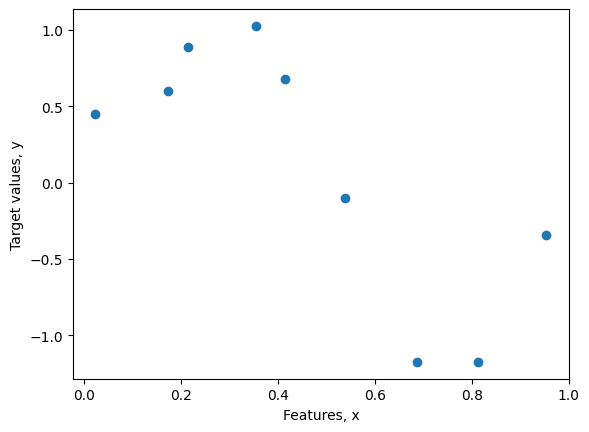

TypeError: too many positional arguments

In [18]:
# Tree Regressor stuff
csvname = "./noisy_sin_subsample_2.csv"
data_regress = np.loadtxt(csvname, delimiter=",")
data_regress = np.array([[x, y] for x, y in zip(*data_regress)])
plt.figure()
plt.scatter(data_regress[:, 0], data_regress[:, 1])
plt.xlabel("Features, x")
plt.ylabel("Target values, y")
plt.show()

mse_depths = []
for depth in range(1, 5):
    regressor = TreeRegressor(data_regress, depth)
    tree = regressor.build_tree()
    mse = 0.0
    for data_point in data_regress:
        mse += (
            data_point[1]
            - predict(tree, data_point, compare_node_with_threshold)
        ) ** 2
    mse_depths.append(mse / len(data_regress))
plt.figure()
plt.plot(mse_depths)
plt.xlabel("Depth")
plt.ylabel("MSE")
plt.show()

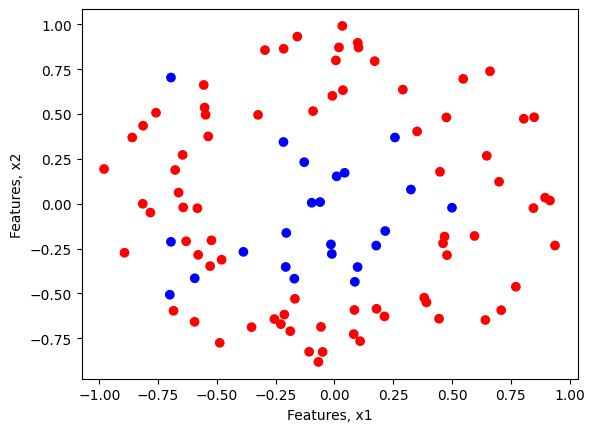

TypeError: type of argument "node" must be __main__.Node; got NoneType instead

In [ ]:
# Tree Classifier stuff
csvname = "new_circle_data.csv"
data_class = np.loadtxt(csvname, delimiter=",")
data_class = np.array([[x1, x2, y] for x1, x2, y in zip(*data_class)])
plt.figure()
plt.scatter(
    data_class[:, 0], data_class[:, 1], c=-data_class[:, 2], cmap="bwr"
)
plt.xlabel("Features, x1")
plt.ylabel("Features, x2")
plt.show()

accuracy_depths = []
for depth in range(1, 8):
    classifier = TreeClassifier(data_class, depth)
    tree = classifier.build_tree()
    correct = 0.0
    for data_point in data_class:
        correct += float(
            data_point[2]
            == predict(tree, data_point, compare_node_with_threshold)
        )
    accuracy_depths.append(correct / len(data_class))
# Plot the MSE
plt.figure()
plt.plot(accuracy_depths)
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.show()